In [3]:
# imports 
import numpy as np 
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import lambertw

In [48]:
def quadratic_error(x_hat, x):
    """
    Compute the quadratic error between the restored signal
    and the ground truth signal.
    """
    error = np.linalg.norm(x_hat - x, ord = 2) ** 2  
    return error

# Part I

## Generation of synthetic data

In [4]:
# Question 1
def get_signal():
    signal = open("signal.txt", "r")
    signal = signal.readlines()
    signal = [float(i.split("\n")[0]) for i in signal]
    return signal
signal = get_signal()

In [5]:
# Question 2
signal = np.array(signal)
N = len(signal)   # 200
T_min = 1
T_max = 1000
log = np.log(T_min / T_max)
T = np.array([T_min * 
              np.exp(
                  -(i - 1) * 
                  (log) / (N - 1)
                  ) 
                  for i in range(1, N + 1)])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


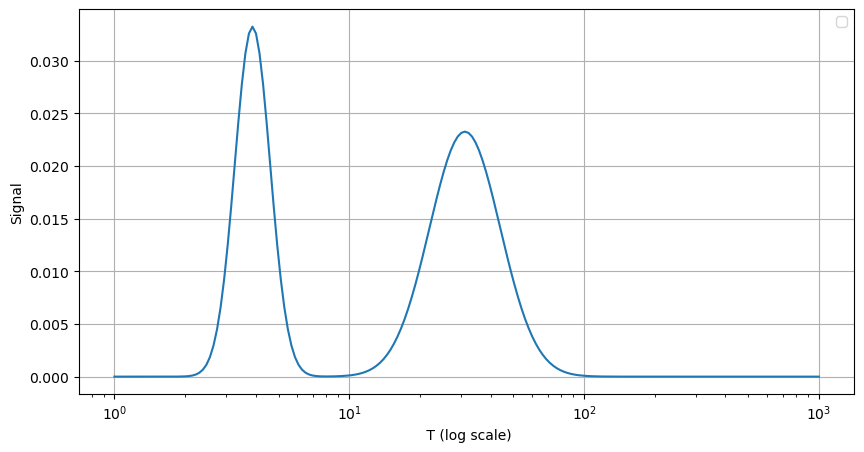

In [6]:
# Question 3 
plt.figure(figsize = (10, 5))
plt.plot(T, signal)
plt.xlabel(" T (log scale)")
plt.ylabel("Signal")    
plt.xscale("log")
plt.grid()
plt.legend()
plt.show()

In [7]:
# Question 4
M = 50
t_min = 0
t_max = 1.5
m = np.arange(1, M + 1)
t_m = t_min + (m - 1) * (t_max - t_min) / (M - 1)

In [8]:
# Question 5
K = np.exp(- np.outer(t_m, T))

In [9]:
# Question 6 
z = np.dot(K, signal)
sigma = 0.01 * z[0]
w = np.random.multivariate_normal(np.zeros(M), (sigma ** 2) * np.eye(M))
y = z + w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


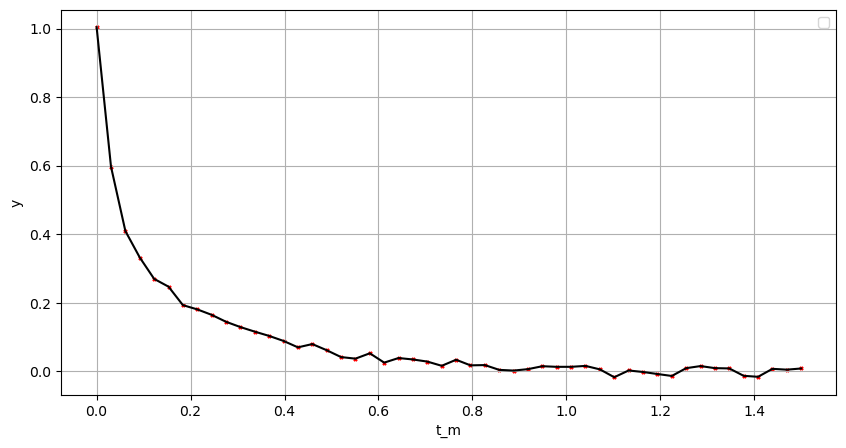

In [10]:
plt.figure(figsize = (10, 5))
plt.plot(t_m, y, color = "black")
plt.scatter(t_m, y, color = "red", s = 5, marker = "x")
plt.xlabel("t_m")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

$ \quad $

---

$ \quad $

## Comparison of regularization strategies

For every penalization functions $g$ listed at the end of the document,
1. Discuss the existence and uniqueness of a solution to
$$ \hat{x} = \text{arg}\min_{x \in \mathbb{R}^N} \frac{1}{2} \parallel Kx - y \parallel^2 + \beta g(x)$$
2. Propose an approach to solve the problem above.
3. Implement the approach and display the restored signal $\hat{x}$
4. Compute the normalized quadratic error between $\hat{x}$ and $\overline{x}$:
$$ E(\hat{x}, \overline{x}) = \frac{\parallel \hat{x} - \overline{x} \parallel^2}{\parallel \overline{x} \parallel^2}$$
5. When needed, search manually for the best choice for parameter $\beta$ in terms of reconstruction error.

---

### Smoothness prior

$$\forall x \in \mathbb{R}^N, \quad g(x) = \frac{1}{2} \parallel Dx \parallel^2$$
where $D \in \mathbb{R}^{N \times N}$ is the discrete gradient operator defined such that:
$$\forall n \in \{1, \ldots, N \}, [Dx]^{(n)} = x^{(n)} - x^{(n-1)}$$
with the circular convention that $x^{(0)} = x^{(N)}$. The role of such regularization term is to promote the reconstruction of smooth signals.

---

### Smoothness prior + constraints


$$ \forall x \in \mathbb{R}^N, \quad g(x) = \frac{1}{2} \parallel Dx \parallel^2 + \iota_{[x_{ \text{min}}, x_{ \text{max}}]^N}(x) $$

with $0 < x_{ \text{min}} < x_{ \text{max}} $ the minimum and maximum values of the original signal $\overline{x}$.

---

#### Sparsity prior

$$\forall x \in \mathbb{R}^N, \quad g(x) = \parallel x \parallel_1$$

---

Optimal beta: 0.4248181818181818


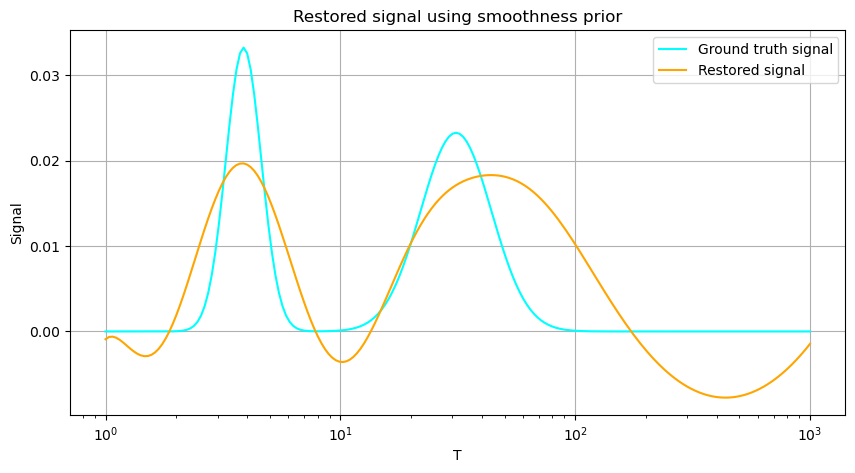

In [33]:
# smoothness prior 
D = np.eye(N) - np.eye(N, k = -1)
D[0, -1] = -1 

error = np.inf 
x_hat = None
beta = None

def Hessian(K, b, D):
    return np.dot(K.T, K) + b * np.dot(D.T, D)

for b in np.linspace(0.001, 1, num = 100):
    H = Hessian(K, b, D)
    x_hat_loop = np.linalg.inv(H).dot(K.T).dot(y)
    current_error = quadratic_error(x_hat_loop, signal)
    if current_error < error:
        error = current_error 
        beta = b
        x_hat = x_hat_loop

print(f"Optimal beta: {beta}")
plt.figure(figsize = (10, 5))
plt.plot(T, signal, label = "Ground truth signal", color = 'cyan')
plt.plot(T, x_hat, label = "Restored signal", color = 'orange')
plt.xlabel("T")
plt.ylabel("Signal")
plt.grid()
plt.legend()
plt.xscale("log")
plt.title("Restored signal using smoothness prior")
plt.show()

In [35]:
print(f"Quadratic error for smoothness prior : {error}")

Quadratic error for smoothness prior : 0.008263275972625012


100%|██████████| 5/5 [00:42<00:00,  8.44s/it]

Optimal beta: 0.5


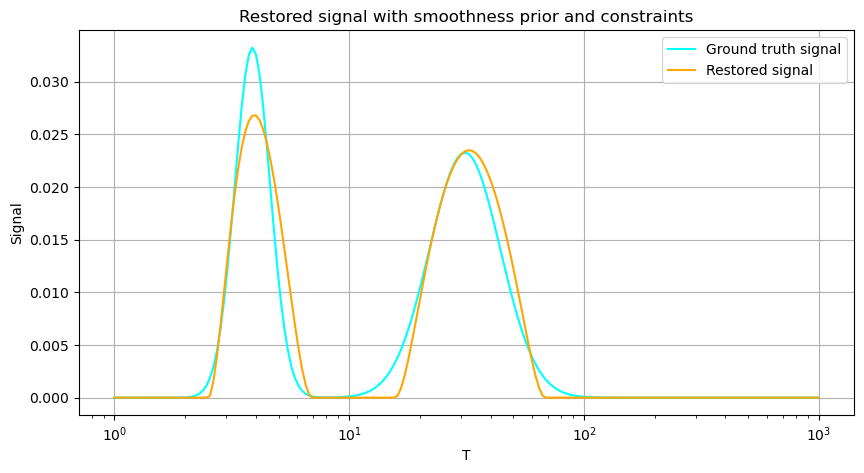

In [37]:
# smoothness prior + constraints 
x_min, x_max = np.min(signal), np.max(signal)

def projected_gradient(x_0, beta, tol = 1e-7, y = y, D = D, x_min = x_min, x_max = x_max):
    def gradient(x, y, K, D, beta):    
        return K.T.dot(K.dot(x)-y) + beta * (D.T.dot(D)).dot(x)
    
    H = Hessian(K, beta, D)
    v , _= np.linalg.eig(H)
    v = np.max(v)
    borne_sup = 2. / v    # for gamma
    gamma = borne_sup / 2.     # arbitrary value
    delta = 2. - gamma*( v / 2.)
    lamb = delta / 2    # arbitrary value
    x = x_0
    step = x - gamma * gradient(x, y, K, D, beta)
    x_next = x + delta * (np.clip(step, x_min, x_max) - x)
    while np.sqrt(np.sum((x_next - x) ** 2)) > tol:
        x = x_next
        step = x - gamma * gradient(x, y, K, D, beta)
        x_next = x + lamb * (np.clip(step, x_min, x_max) - x)
    x = x_next
    return x

error = np.inf 
x_hat = None
beta = None
x_0 = ((x_max - x_min) / 2) * np.ones(N)

for b in tqdm([0.01, 0.1, 0.5, 0.7, 1]):
    x_hat_loop = projected_gradient(x_0 = x_0, beta = b, tol = 1e-6, y = y, D = D, x_min = x_min, x_max = x_max)
    current_error = quadratic_error(x_hat_loop, signal)
    if current_error < error:
        error = current_error 
        beta = b
        x_hat = x_hat_loop

print(f"Optimal beta: {beta}")
plt.figure(figsize = (10, 5))
plt.plot(T, signal, label = "Ground truth signal", color = 'cyan')
plt.plot(T, x_hat, label = "Restored signal", color = 'orange')
plt.xlabel("T")
plt.ylabel("Signal")
plt.grid()
plt.legend()
plt.title("Restored signal with smoothness prior and constraints")
plt.xscale("log")
plt.show()

In [38]:
print(f"Quadratic error for smoothness prior + constraints: {error}")

Quadratic error for smoothness prior + constraints: 0.000725062511362084


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]

Optimal beta: 0.01


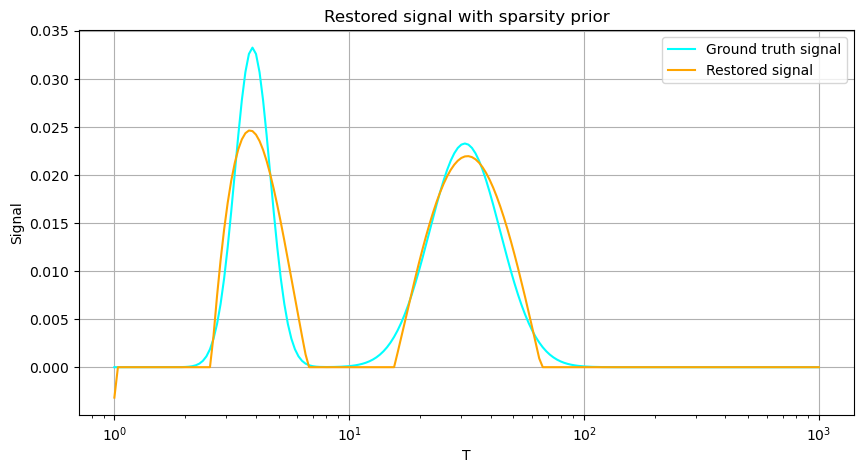

In [39]:
# Sparsity prior

def projected_gradient2(x_0, beta, tol = 1e-6, y = y, D = D):

    def gradient(x, y, K, D, beta):    
        return K.T.dot(K.dot(x)-y) + beta * (D.T.dot(D)).dot(x)
    
    
    H = Hessian(K, beta, D)
    v , _= np.linalg.eig(H)
    v = np.max(v)
    gamma = 1 / v     # arbitrary value
    delta = 2. - gamma * ( v / 2.)
    lamb = 0.95

    x = x_0
    step = x - gamma * gradient(x, y, K, D, beta)
    x_next = x + delta * (np.sign(step) * np.maximum(np.abs(step) - (beta / 2 * gamma), 0) - x)
    while np.any(np.abs(x_next - x) / (np.abs(x) + 1e-8) > tol):
        x = x_next
        step = x - gamma * gradient(x, y, K, D, beta)
        x_next = x + lamb * (np.sign(step) * np.maximum(np.abs(step) - (beta / 2 * gamma), 0) - x)
    x = x_next
    return x

error = np.inf 
x_hat = None
beta = None
x_0 = ((x_max - x_min) / 2) * np.ones(N)

for b in tqdm([0.01, 0.1, 0.5, 0.7, 1]):
    x_hat_loop = projected_gradient2(x_0 = x_0, beta = b, tol = 1e-3, y = y, D = D)
    current_error = quadratic_error(x_hat_loop, signal)
    if current_error < error:
        error = current_error 
        beta = b
        x_hat = x_hat_loop

print(f"Optimal beta: {beta}")
plt.figure(figsize = (10, 5))
plt.plot(T, signal, label = "Ground truth signal", color = 'cyan')
plt.plot(T, x_hat, label = "Restored signal", color = 'orange')
plt.xlabel("T")
plt.ylabel("Signal")
plt.grid()
plt.legend()
plt.title("Restored signal with sparsity prior")
plt.xscale("log")
plt.show()

In [40]:
print(f"Quadratic error for sparsity prior: {error}")

Quadratic error for sparsity prior: 0.000833198123736007


End of party I.

# Part II : Maximum entropy regularization

In [20]:
def ent(x):
    """ Compute the entropy of a signal x 
    
    Parameters
    ----------
    x : np.array
        Signal
        
    Returns
    -------
    entropy : np.array
        Entropy of the signal
    """
    x = np.array(x)
    L, N = x.shape
    entropy = np.zeros(L)
    for l in range(L):
        for n in range(N):
            u = x[l, n]
            if u > 0:
                entropy[l] += u * np.log(u)
            elif u == 0:
                entropy[l] += 0
            else:
                entropy[l] += np.inf
                break          
    return entropy

def objective_function(x, K, D, y, beta = 0.01):
    return (np.linalg.norm(K.dot(x) - y, ord = 2) ** 2) / 2 + beta * np.linalg.norm(D.dot(x), ord = 1)

In [77]:
# Lambert function
def W_exp(u):
    
    m = u.shape[0]
    output = np.zeros((m,1))
    
    for index in range(m):
        val = u[index,0]
        
        if val >= 100:
            output[index,0] = val - np.log(val)
    
        if val < 100 and val > - 20 :
            w = 1
            v = 0
            while abs(w - v)/abs(w) > 1e-6:
                v = w
                e = np.exp(w)
                f = w*e - np.exp(val)
                w = w - f/((e*(w+1) - (w+2)*f/(2*w+2)))
            output[index,0] = w
            
        if val <=-20:
            output[index,0] = 0        
        
    return output

In [21]:
# Define the gradient of f(x)
def gradient_f(x, K, y):
    """
    Compute the gradient of the function f(x) = ||Kx - y||^2.

    Parameters:
    - x: Current point (numpy array).
    - K: Matrix (numpy array).
    - y: Vector (numpy array).

    Returns:
    - Gradient of f(x) (numpy array).
    """
    return K.T @ (K @ x - y)

# Define the proximal operator for the entropy
def prox_entropy(v, beta):
    """
    Compute the proximal operator of the entropy regularizer.

    Parameters:
    - v: Input vector (numpy array).
    - beta: Regularization parameter (float).

    Returns:
    - Proximal operator result (numpy array).
    """
    x_prox = np.zeros_like(v)

    for n, v_n in enumerate(v):
        if v_n <= 0:
            x_prox[n] = 0
        else:
            u = (v_n / beta) - 1 + np.log(1 / beta)

            # Approximation for large u values
            if u > 100:
                w = u - np.log(u)
            else:
                w = lambertw(np.exp(u))
            
            x_prox[n] = beta * np.real(w)
    
    return x_prox

In [22]:
# Parameters
gamma = 1 / np.linalg.norm(K, ord = 2) ** 2  # Step size based on the spectral norm

### Forward-Backward algorithm

Let $f \in \Gamma_0(H)$.  
Let $g \in \Gamma_0(H)$ be differentiable with a $\nu$-Lipschitzian gradient where $\nu \in ]0, +\infty[$.  
Let $\gamma \in ]0, 2/\nu[$ and $\delta = 2 - \gamma\nu/2 \in ]1, 2[$.  

Let $(\lambda_n)_{n \in \mathbb{N}}$ be a sequence in $[0, \delta]$ such that $\sum_{n \in \mathbb{N}} \lambda_n(\delta - \lambda_n) = +\infty$.  
We assume that $\mathrm{Argmin}(f + g) \neq \emptyset$.  

Let $x_0 \in H$ and define the sequence $(x_n)_{n \in \mathbb{N}}$ by:  

$\quad \forall n \in \mathbb{N}$, 
\begin{aligned}
    y_n &= x_n - \gamma \nabla g(x_n), \\
    x_{n+1} &= x_n + \lambda_n (\mathrm{prox}_{\gamma f}(y_n) - x_n),
\end{aligned}



Then, $(x_n)_{n \in \mathbb{N}}$ converges weakly to a minimizer of $f + g$.

In [16]:
def forward_backward(K, y, beta, gamma, max_iter = 50000, tol = 1e-7, lamb = 1.0):
    """
    Implements the Forward-Backward algorithm.

    Parameters:
    - K: Matrix (numpy array).
    - y: Observed data (numpy array).
    - beta: Regularization parameter (float).
    - gamma: Step size parameter (float).
    - max_iter: Maximum number of iterations (int, default=50000).
    - tol: Convergence tolerance (float, default=1e-7).
    - lamb: Relaxation parameter (float, default=1.0).

    Returns:
    - x_hat: Estimated solution (numpy array).
    - residuals: List of residual norms for each iteration (list of floats).
    """
    N = K.shape[1]
    x = np.zeros(N)  # Initialization
    residuals = []  # Stores the norm of differences

    for t in range(max_iter):
        # Forward step
        z = x - gamma * gradient_f(x, K, y)
        
        # Backward step
        x_new = x + lamb * (prox_entropy(z, gamma * beta) - x)
        
        # Compute and store residuals
        residuals.append(np.linalg.norm(x_new - x))
        
        # Check for convergence
        if residuals[-1] < tol:
            break
        
        x = x_new

    return x, residuals

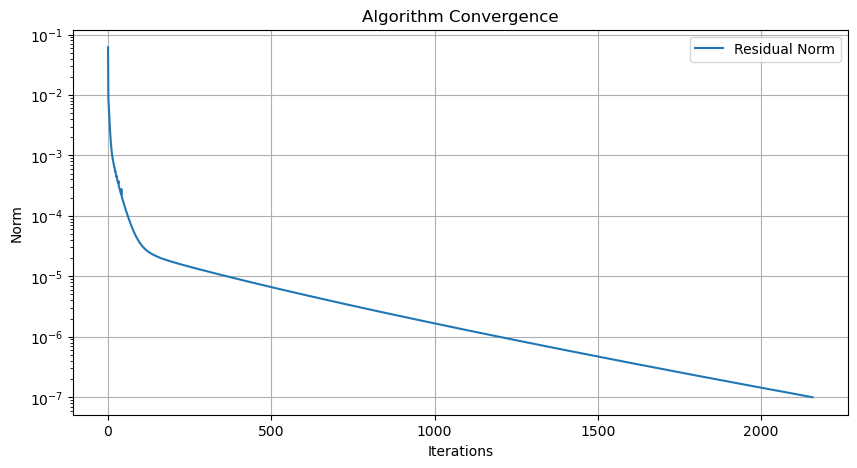

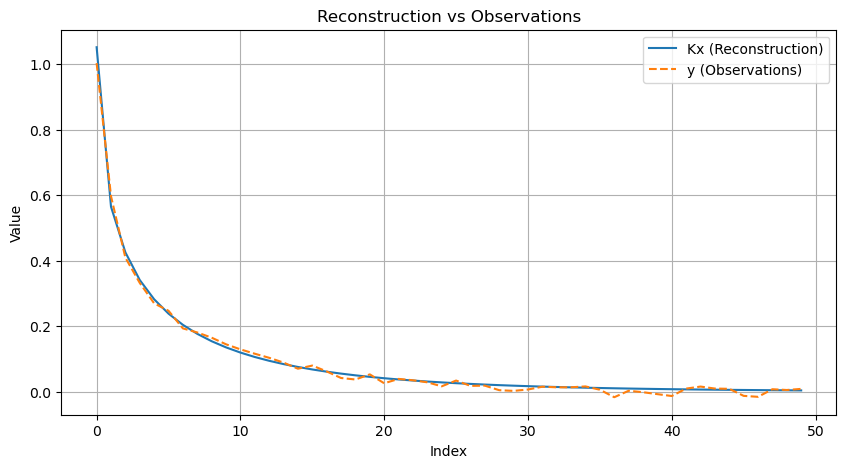

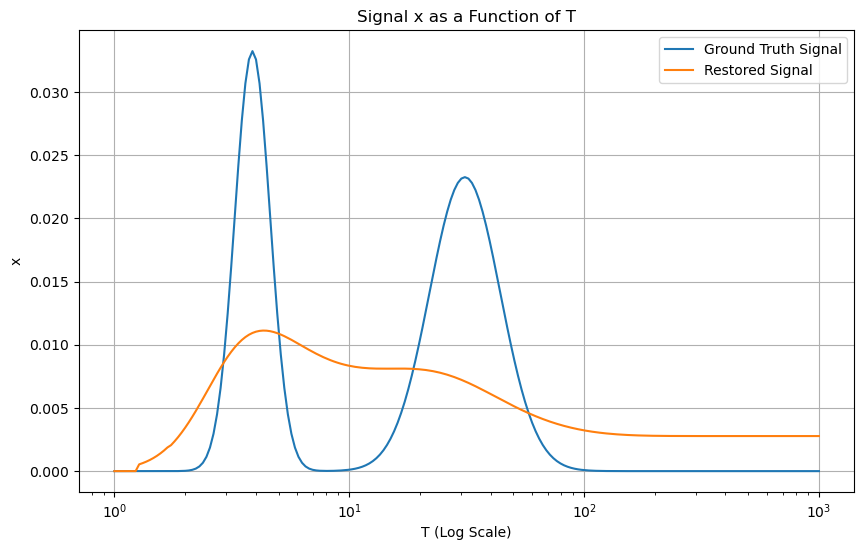

In [23]:
# Run the Forward-Backward algorithm
x_hat, residuals = forward_backward(K, y, beta, gamma)

# Convergence visualization
plt.figure(figsize=(10, 5))
plt.plot(residuals, label="Residual Norm")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Norm")
plt.title("Algorithm Convergence")
plt.legend()
plt.grid()
plt.show()

# Comparison of Kx and y
plt.figure(figsize=(10, 5))
plt.plot(K @ x_hat, label="Kx (Reconstruction)")
plt.plot(y, label="y (Observations)", linestyle="dashed")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Reconstruction vs Observations")
plt.legend()
plt.grid()
plt.show()

# Display original signal vs reconstructed signal
plt.figure(figsize=(10, 6))
plt.plot(T, signal, linestyle='-', label='Ground Truth Signal')
plt.plot(T, x_hat, linestyle='-', label='Restored Signal')
plt.xlabel("T (Log Scale)")
plt.ylabel("x")
plt.xscale('log')
plt.title("Signal x as a Function of T")
plt.grid()
plt.legend()
plt.show()

### Douglas-Rachford algorithm 

Let $H$ be a Hilbert space.  
Let $f, g \in \Gamma_0(H)$.  

Let $\gamma \in ]0, +\infty[$ and let $(\lambda_n)_{n \in \mathbb{N}}$ be a sequence in $[0, 2]$ such that  

$ \sum_{n \in \mathbb{N}} \lambda_n(2 - \lambda_n) = +\infty$ .

We assume that $\mathrm{zer}(\partial f + \partial g) \neq \emptyset$.  

Let $x_0 \in H$ and define the sequences $(y_n)_{n \in \mathbb{N}}$ and $(z_n)_{n \in \mathbb{N}}$ by:  

$ \forall n \in \mathbb{N}$ ,
\begin{aligned}
    y_n &= \mathrm{prox}_{\gamma g}(x_n), \\
    z_n &= \mathrm{prox}_{\gamma f}(2y_n - x_n),
\end{aligned}

In [24]:
def prox_f(z, lambda_):
    n = K.shape[1]
    KtK = K.T @ K
    I = np.eye(n)
    A = KtK + (1 / lambda_) * I
    b = K.T @ y + (1 / lambda_) * z
    prox = np.linalg.solve(A, b)  # resolve Ax = b
    return prox

def douglas_rachford(K, y, beta, gamma, max_iter=50000, tol=1e-7, lamb=1.0):
    """
    Implements the Douglas-Rachford splitting algorithm.

    Parameters:
    - K: Matrix (numpy array).
    - y: Observed data (numpy array).
    - beta: Regularization parameter (float).
    - gamma: Step size parameter (float).
    - max_iter: Maximum number of iterations (int, default=50000).
    - tol: Convergence tolerance (float, default=1e-7).
    - lamb: Relaxation parameter (float, default=1.0).

    Returns:
    - x_hat: Estimated solution (numpy array).
    - residuals: List of residual norms for each iteration (list of floats).
    """
    N = K.shape[1]
    x = np.zeros(N)  # Initialization
    residuals = []  # Store the norm of differences

    for t in range(max_iter):
        # Proximal operations
        y_prox = prox_entropy(x, beta * gamma)
        z_prox = prox_f(2 * y_prox - x, gamma)
        
        # Update step
        x_new = x + lamb * (z_prox - y_prox)
        
        # Compute and store residuals
        residuals.append(np.linalg.norm(x_new - x))
        
        # Check for convergence
        if residuals[-1] < tol:
            break
        
        x = x_new

    return x, residuals

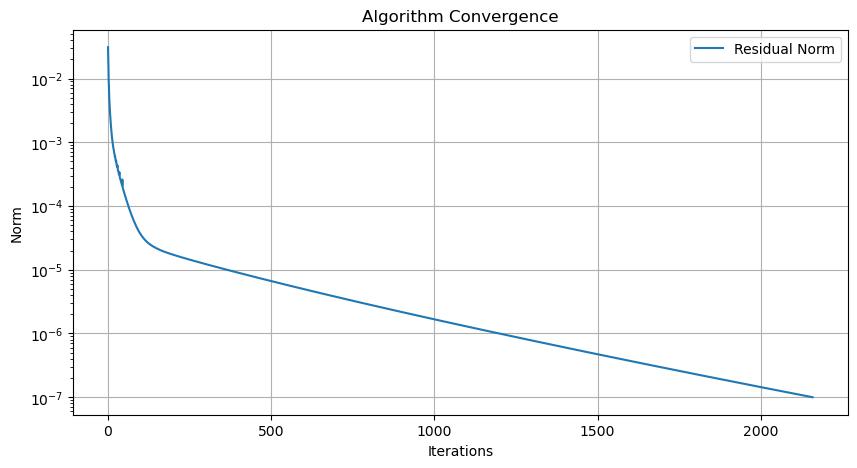

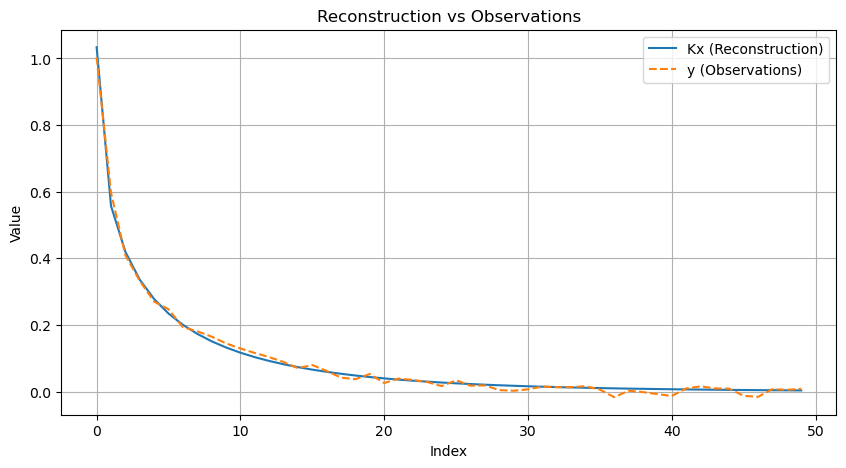

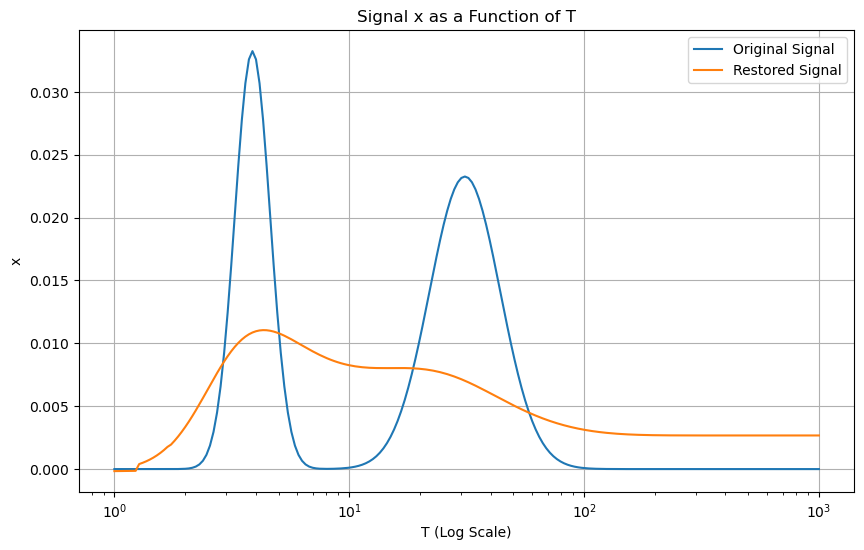

In [25]:
# Run the Douglas-Rachford algorithm
x_hat, residuals = douglas_rachford(K, y, beta, gamma)

# Convergence visualization
plt.figure(figsize=(10, 5))
plt.plot(residuals, label="Residual Norm")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Norm")
plt.title("Algorithm Convergence")
plt.legend()
plt.grid()
plt.show()

# Comparison of Kx and y
plt.figure(figsize=(10, 5))
plt.plot(K @ x_hat, label="Kx (Reconstruction)")
plt.plot(y, label="y (Observations)", linestyle="dashed")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Reconstruction vs Observations")
plt.legend()
plt.grid()
plt.show()

# Display the original and reconstructed signals
plt.figure(figsize=(10, 6))
plt.plot(T, signal, linestyle='-', label='Original Signal')
plt.plot(T, x_hat, linestyle='-', label='Restored Signal')
plt.xlabel("T (Log Scale)")
plt.ylabel("x")
plt.xscale('log')
plt.title("Signal x as a Function of T")
plt.grid()
plt.legend()
plt.show()

## Choosing a better Beta 

#### What is the best choice of parameter $\beta $ for Forward-Backward algorithm ? 

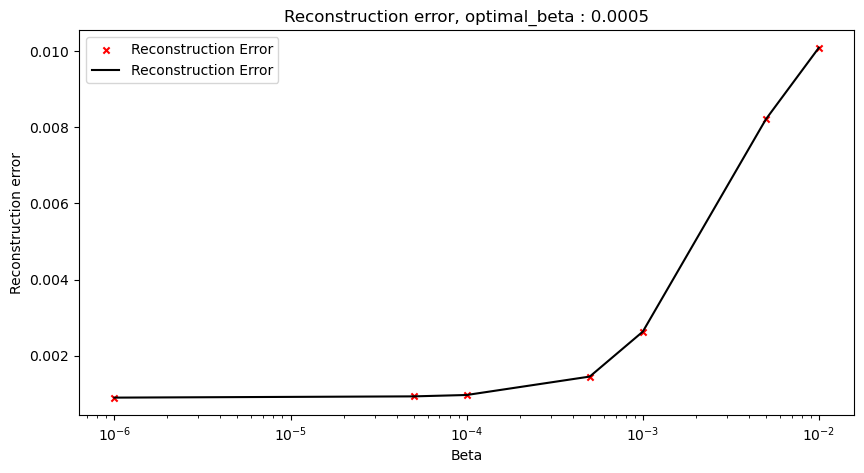

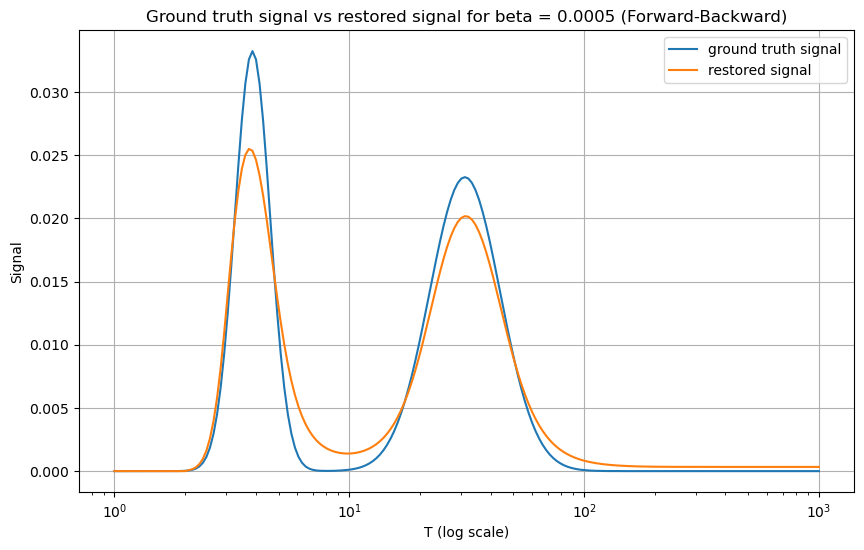

In [42]:
beta = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.000001]  

errors = []
for b in beta:
    x_hat, residuals = forward_backward(K, y, b, gamma, max_iter=10000)
    error  = quadratic_error(x_hat, signal)
    errors.append(error)


optimal_beta = 0.0005

x_hat, _ = forward_backward(K, y, optimal_beta, gamma, max_iter=50000)



# Reconstruction errors
plt.figure(figsize=(10, 5))
plt.scatter(beta, errors, label = "Reconstruction Error", color = "red", s = 20, marker = "x")
plt.plot(beta, errors, label = "Reconstruction Error", color = "black")
plt.xlabel("Beta")
plt.xscale("log")
plt.ylabel("Reconstruction error")
plt.title(f"Reconstruction error, optimal_beta : {optimal_beta}")
plt.legend()
plt.show()


# Best beta
plt.figure(figsize=(10, 6))
plt.plot(T, signal, linestyle = '-', label = 'ground truth signal')
plt.plot(T, x_hat, linestyle = '-', label = 'restored signal')
plt.xlabel("T (log scale)")
plt.ylabel("Signal")
plt.xscale('log')
plt.title(f"Ground truth signal vs restored signal for beta = {optimal_beta} (Forward-Backward)")
plt.grid()
plt.legend()
plt.show()

In [45]:
print(f"Quadratic error for entropy with backward-forward algorithm: {errors[3]}")

Quadratic error for entropy with backward-forward algorithm: 0.0014490832617651262


#### What is the best choice of parameter $\beta $ for Douglas-Rashford algorithm ? 

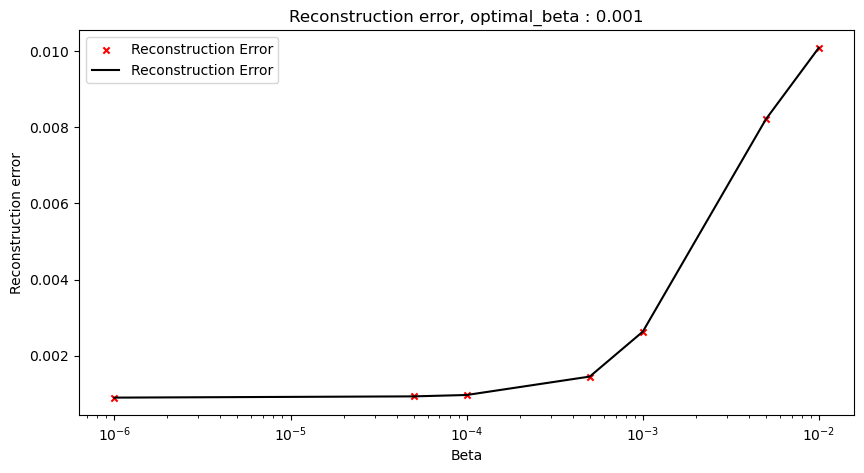

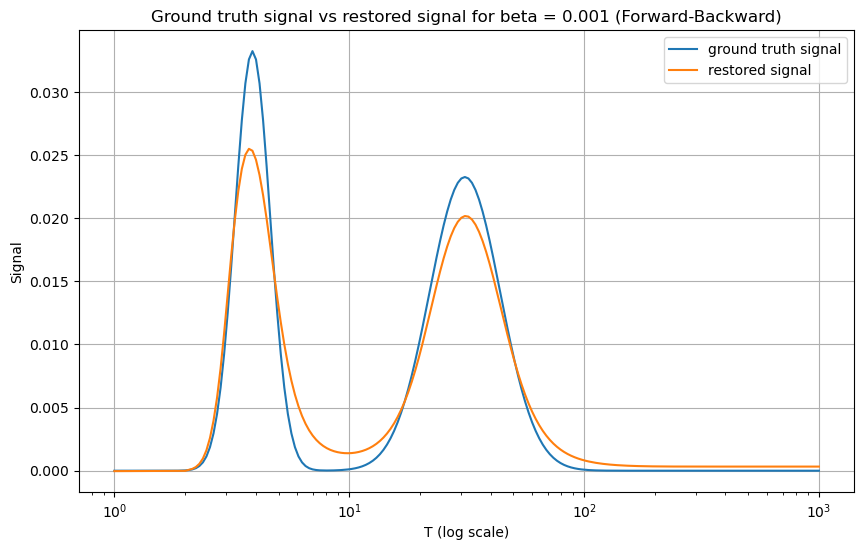

In [44]:
beta = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.000001]  

errors = []
for b in beta:
    x_hat, residuals = forward_backward(K, y, b, gamma, max_iter = 10000)
    error  = quadratic_error(x_hat, signal)
    errors.append(error)

x_hat, _ = douglas_rachford(K, y, optimal_beta, gamma, max_iter = 50000)

optimal_beta = 0.001

# Reconstruction errors
plt.figure(figsize=(10, 5))
plt.scatter(beta, errors, label = "Reconstruction Error", color = "red", s = 20, marker = "x")
plt.plot(beta, errors, label = "Reconstruction Error", color = "black")
plt.xlabel("Beta")
plt.xscale("log")
plt.ylabel("Reconstruction error")
plt.title(f"Reconstruction error, optimal_beta : {optimal_beta}")
plt.legend()
plt.show()


# Best beta
plt.figure(figsize=(10, 6))
plt.plot(T, signal, linestyle = '-', label = 'ground truth signal')
plt.plot(T, x_hat, linestyle = '-', label = 'restored signal')
plt.xlabel("T (log scale)")
plt.ylabel("Signal")
plt.xscale('log')
plt.title(f"Ground truth signal vs restored signal for beta = {optimal_beta} (Forward-Backward)")
plt.grid()
plt.legend()
plt.show()

In [46]:
print(f"Quadratic error for entropy with Douglas-Rashford algorithm: {errors[2]}")

Quadratic error for entropy with Douglas-Rashford algorithm: 0.002630023145947489


#### Question 7 : Compare the maximum entropy regularization with the ones proposed in the previous part in terms of reconstruction quality.

We've fixed the tolerance to tol = 1e-7 in all the algorithms that rely on a stopping criterion (that only excludes the smoothness prior).

Je sais pas quoi diiiiirrrrreeeeeeeuuuuuuuhhhhhh

In practice, adjusting the parameter $\beta $ may be difficult, while one has often informations about the level of noise corrupting the data. A more practical formulation may therefore be obtained by solving the following optimization problem :

## Constrained problem 

\begin{aligned}
& \text{minimize} && \mathrm{ent}(x) \\
& \text{subject to} && \|Kx - y\|_2^2 \leq \eta M \sigma^2,
\end{aligned}

Equivalently, we would like to solve the following problem: 

\begin{aligned}
& \text{minimize} && \mathrm{ent}(x) + \iota_{\mathcal{B}_2(y, \sqrt{\eta M \sigma^2})}(K x),
\end{aligned}

where $ \iota_{\mathcal{B}_2(y, \sqrt{\eta M \sigma^2})}(K x) $ is the indicator function of the $ \ell_2 $ -norm ball $ \mathcal{B}_2(y, \sqrt{\eta M \sigma^2}) $, defined as:

$
\iota_{\mathcal{B}_2(y, \sqrt{\eta M \sigma^2})}(Kx) = 
\begin{cases} 
0, & \text{if } K x \in \mathcal{B}_2(y, \sqrt{\eta M \sigma^2}), \\
+\infty, & \text{otherwise}.
\end{cases}
$

where $ \mathcal{B}_2(y, \sqrt{\eta M \sigma^2}) $ denotes the $ \ell_2 $-norm ball centered on $y $ and of radius $ \sqrt{\eta M \sigma^2}$.

Let's use the **Parallel form of Douglas-Rashford**.

See HW.pdf for further details.

In [58]:
def projB(v, y, eta = 1):
    """
    Project a vector `v` onto the ℓ2-norm ball centered at `y` 
    with radius `sigma * sqrt(M * eta)`.
    
    Parameters:
        v (np.ndarray): Input vector to project.
        y (np.ndarray): Center of the ℓ2-norm ball.
        sigma (float): Scaling factor for the ball radius.
        M (float): Size parameter of the ball.
        eta (float, optional): Additional scaling factor (default is 1).
    
    Returns:
        np.ndarray: The projected vector.
    """
    radius = sigma * np.sqrt(M * eta)
    return v + (y - v)/(np.linalg.norm(y - v)) * max(0, np.linalg.norm(y - v) - radius) 

In [80]:
def ppxa(K, y, x_init, gamma = 0.1, eps = 1e-7, max_iter = 10 ** 5):
    """
    Parallel Proximal Algorithm (PPXA) for solving optimization problems.
    
    Parameters:
        K (np.ndarray): Input matrix.
        y (np.ndarray): Target vector.
        x_init (np.ndarray): Initial vector for the algorithm.
        gamma (float, optional): Regularization parameter for entropy proximal operator (default: 0.1).
        eps (float, optional): Convergence tolerance (default: 1e-3).
        max_iter (int, optional): Maximum number of iterations (default: 10,000).
    
    Returns:
        np.ndarray: The optimized solution `v`.
    """ 
    def prox_gamma_ent(x, gamma = 1):
        return gamma * W_exp((x/gamma)-1-np.log(gamma))
    
    # Initialize variables
    x_1 = x_init.copy()
    x_2 = K @ x_1
    v = np.linalg.solve(K.T @ K + np.eye(K.shape[1]), x_1 + K.T @ x_2)
    
    for iteration in range(1, max_iter + 1):
        # Compute lambda for step size
        lambda_ = 1 - 1 / iteration

        # Apply proximal operators
        y_1 = prox_gamma_ent(x_1, gamma = gamma)
        y_2 = projB(x_2, y.reshape(-1, 1), eta=1)
        
        # Update combined variable
        c = np.linalg.solve(K.T @ K + np.eye(K.shape[1]), y_1 + K.T @ y_2)
        
        # Update variables using the relaxation parameter
        x_1 += lambda_ * (2 * c - v - y_1)
        x_2 += lambda_ * (K @ (2 * c - v) - y_2)
        v += lambda_ * (c - v)
        
        # Check for convergence
        if np.linalg.norm(2 * c - v - y_1) < eps and np.linalg.norm(K @ (2 * c - v) - y_2) < eps:
            print(f"Converged in {iteration} iterations.")
            break
    else:
        print("Reached maximum iterations without convergence.")
    
    return v

Converged in 8020 iterations.


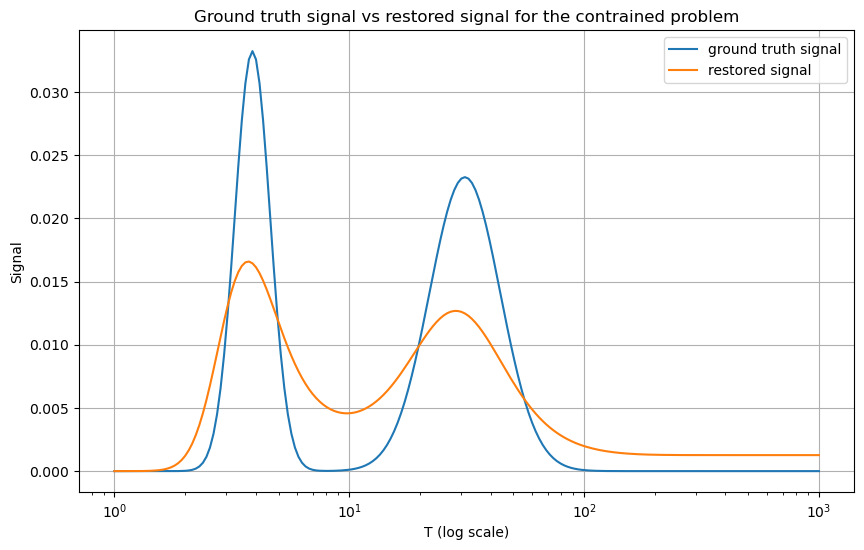

In [81]:
x_init = np.ones((K.shape[1],1))
x_hat = ppxa(K = K, y = y, x_init = x_init) 

plt.figure(figsize=(10, 6))
plt.plot(T, signal, linestyle = '-', label = 'ground truth signal')
plt.plot(T, x_hat, linestyle = '-', label = 'restored signal')
plt.xlabel("T (log scale)")
plt.ylabel("Signal")
plt.xscale('log')
plt.title(f"Ground truth signal vs restored signal for the contrained problem")
plt.grid()
plt.legend()
plt.show()

 10%|█         | 1/10 [01:42<15:20, 102.25s/it]

Converged in 40208 iterations.


 20%|██        | 2/10 [02:00<07:02, 52.77s/it] 

Converged in 8020 iterations.


 30%|███       | 3/10 [02:08<03:47, 32.43s/it]

Converged in 3607 iterations.


 40%|████      | 4/10 [02:11<02:05, 20.86s/it]

Converged in 1398 iterations.


 50%|█████     | 5/10 [02:13<01:10, 14.09s/it]

Converged in 964 iterations.


 60%|██████    | 6/10 [02:15<00:39,  9.84s/it]

Converged in 583 iterations.


 70%|███████   | 7/10 [02:17<00:21,  7.19s/it]

Converged in 661 iterations.


 80%|████████  | 8/10 [02:22<00:13,  6.53s/it]

Converged in 1226 iterations.


 90%|█████████ | 9/10 [02:28<00:06,  6.59s/it]

Converged in 1560 iterations.


100%|██████████| 10/10 [02:29<00:00, 15.00s/it]

Converged in 536 iterations.


Converged in 1226 iterations.


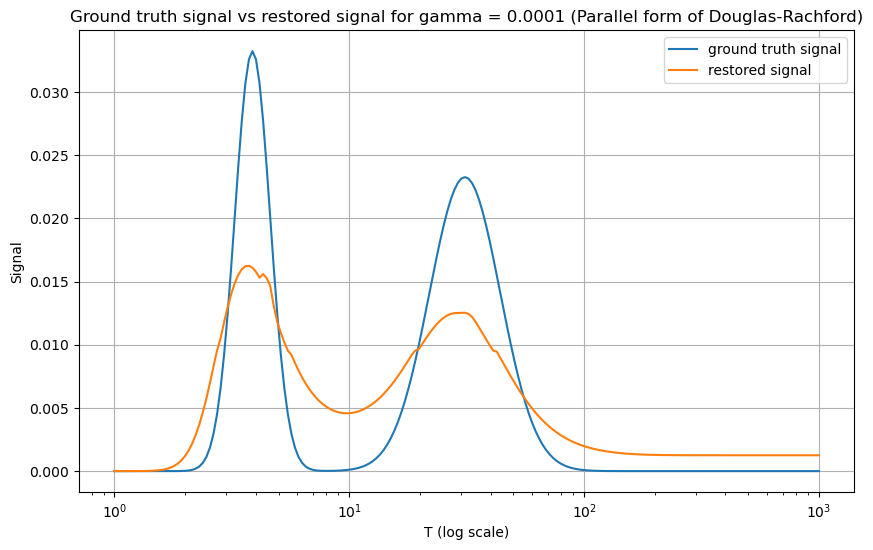

In [82]:
gammas = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.000001]  

best_gamma = 0.5
best_error = np.inf
for gamma in tqdm(gammas):
    x_hat = ppxa(K = K, y = y, x_init = x_init, gamma = gamma) 
    error  = quadratic_error(x_hat, signal)
    if error < best_error:
        best_error = error
        best_gamma = gamma

x_hat= ppxa(K = K, y = y, x_init = x_init, gamma = best_gamma) 


# Best beta
plt.figure(figsize=(10, 6))
plt.plot(T, signal, linestyle = '-', label = 'ground truth signal')
plt.plot(T, x_hat, linestyle = '-', label = 'restored signal')
plt.xlabel("T (log scale)")
plt.ylabel("Signal")
plt.xscale('log')
plt.title(f"Ground truth signal vs restored signal for gamma = {best_gamma} (Parallel form of Douglas-Rachford)")
plt.grid()
plt.legend()
plt.show()

In [84]:
print(best_gamma)

0.0001
